In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from py12box_invert.invert import Invert
from py12box_laube import get_data
from py12box_agage.utils import get_inversion_params
import pandas as pd

In [2]:
# Run for "CFC-112", "CFC-112a", "CFC-113","CFC-113a", "CFC-114", "CFC-114a"

# Uncertainty for 112a, 112 and 113a from Laube 2014
# Uncertainty for 114a say 20% as Davis et al uncertainty is tiny
# Others come from file (SPARC report)
lifetime_uncertainty_dict = {"CFC-112a":0.55,"CFC-112":0.35, "CFC-113a":0.8,
                            "CFC-113":0.2, "CFC-114":0.2, "CFC-114a":0.2, 
                            "CFC-115":0.2, "CFC-13":0.2}   

lifetime_strat = {"CFC-112a":52., "CFC-113a":55.,"CFC-114a":105., 
                            "CFC-115":540, "CFC-13":640}

species_list = ["CFC-112a", "CFC-113a", "CFC-114a"]
network = "laube" #"allagage" # agage or laube or allagage
# species_list = ["CFC-112", "CFC-112a", "CFC-113","CFC-113a", "CFC-114", "CFC-114a"]
# species_list = ["CFC-115","CFC-13"] #"CFC-114", 
for species in species_list:
    

    if species in lifetime_strat.keys():
        model_args = {"lifetime_strat":lifetime_strat[species]}
    else:
        model_args = {}

    # Set a minimum mf uncertainty
    if "a" not in species:
        if species == "CFC-112":
            min_unc = 0.0025
        else:
            min_unc = 0.05
    # elif species == "CFC-114a":
    #     min_unc = 0.0025
    else:
        min_unc = 0.

    scale_error = 0.03
    if species == "CFC-114a":
        uncertainty_scale = 0.05
    else:
        uncertainty_scale = 0.2
    
    lifetime_uncertainty = lifetime_uncertainty_dict[species]

    print(f"... {species}")

    # Work out paths
    project_path = get_data(f"{species}")
    if network == "agage":
        parts = list(project_path.parts)
        parts[-2] = parts[-2] + "_agage"
        project_path = Path(*parts)
        network_in = network.copy()
    elif network == "allagage":
        parts = list(project_path.parts)
        parts[-2] = parts[-2] + "_allagage"
        project_path = Path(*parts)
        network_in = network.replace("all","")
    else:
        network_in = network#.copy()
    obs_path = project_path / f"inputs/{species}_obs_{network_in}.csv"
    output_path = project_path / f"outputs/{species}_out.p"

    nthreads = 1

    if not output_path.parent.exists():
        output_path.parent.mkdir()

    # Set up inversion
    inv = Invert(project_path / "inputs", species,
                obs_path = obs_path,
                method="iterative_rigby14", #"analytical_gaussian",#"rigby14",#
                n_threads=nthreads,
                sensitivity_freq="yearly",
                end_year=2021.,
                model_args = model_args)
                

    inv.obs.mf_uncertainty[inv.obs.mf_uncertainty < min_unc] = min_unc

    # Calculate emissions uncertainty
    emissions_box = inv.mod.emissions.max(axis=0)

    invert_uncertainty = inv.mod.emissions.sum(axis=1).mean() * uncertainty_scale
    invert_uncertainty_box = np.sqrt(invert_uncertainty**2 * emissions_box / emissions_box.sum())
    invert_uncertainty_min = invert_uncertainty*0.01

    invert_uncertainty_box[invert_uncertainty_box < invert_uncertainty_min] = invert_uncertainty_min

    # Run inversion
    inv.run_inversion(invert_uncertainty_box,
                    lifetime_error=lifetime_uncertainty,
                    scale_error=scale_error)

    # Save outputs
    # inv.save(output_path)

    # # Write to csv
    # inv.to_csv(project_path / "outputs/")
    
    # plt.figure()
    # plt.plot(inv.outputs.emissions_global_annual[0],inv.outputs.emissions_global_annual[1])
    # plt.plot(inv.outputs.emissions_global_annual[0],inv.outputs.emissions_global_annual[1]+
    # inv.outputs.emissions_global_annual[2], "b:")
    # plt.plot(inv.outputs.emissions_global_annual[0],inv.outputs.emissions_global_annual[1]-
    # inv.outputs.emissions_global_annual[2], "b:")
    # #plt.xlim(2010,2021)
    # #plt.ylim(-10,10)
    # plt.plot(inv.mod_prior.time, inv.mod_prior.emissions.sum(1), "r")
    # plt.ylabel(species)

    
    species_list = ["CFC-112", "CFC-112a", "CFC-113","CFC-113a", "CFC-114", "CFC-114a"]
    lpath = Path("/user/home/lw13938/work/py12box_laube/data/")
    emissions = {}


    df = pd.read_csv(lpath / species / f"outputs/{species}_Global_annual_emissions.csv", comment="#")
    emissions[species] = {"date":df.Decimal_date, "emissions":df.Global_annual_emissions,
                            "sd":df["Global_annual_emissions_1-sigma"]} 
    ratio = np.mean(emissions[species]["emissions"] / inv.outputs.emissions_global_annual[1][3:])
    print(f"{species} {ratio}")


... CFC-112a
Setting up inversion for CFC-112a

No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
... completed in 3 iterations
... stratospheric lifetime: 52.1
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e12
... overall lifetime: 52.05
... done in 13.1226 s
Calculating flux sensitivity on 1 threads...
... done
Spinning up for 9 years and estimating initial conditions...
... done
Run inversion...


<ipython-input-2-cccbe7507eee>:78: RuntimeWarning: invalid value encountered in less
  inv.obs.mf_uncertainty[inv.obs.mf_uncertainty < min_unc] = min_unc


... done
Calculating outputs...
... calculating posterior ensembles
... done

CFC-112a 1.064060478532091
... CFC-113a
Setting up inversion for CFC-113a

No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
... completed in 3 iterations
... stratospheric lifetime: 55.0
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e12
... overall lifetime: 55.05
... done in 0.0020 s
Calculating flux sensitivity on 1 threads...
... done
Spinning up for 9 years and estimating initial conditions...
... done
Run inversion...
... done
Calculating outputs...
... calculating posterior ensembles
... done

CFC-113a 1.0107719064927092
... CFC-114a
Setting up inversion for CFC-114a

No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
... completed in 2 iterations
... stratospheric lifetime: 105.1
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e1

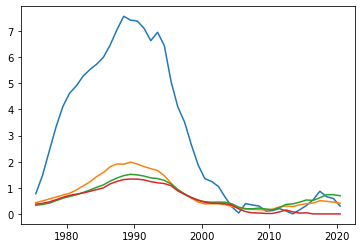

In [43]:
plt.plot(inv.outputs.emissions_annual[0],inv.outputs.emissions_annual[1])
# plt.xlim(1998,2004)

(2010.0, 2021.0)

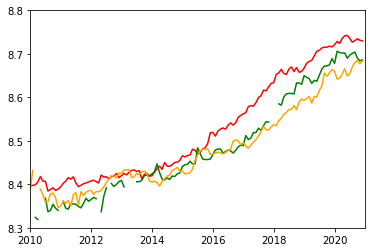

In [44]:
for i, c in enumerate(["r","b","g","orange"]):
    plt.plot(inv.obs.time,inv.obs.mf[:,i], color=c)
    # plt.plot(inv.outputs.mf_model[0], inv.outputs.mf_model[1][:,i], color=c)# plt.xlim((2001,2002))
plt.ylim((8.3,8.8))
# plt.ylim((3,3.5))
plt.xlim((2010,2021))

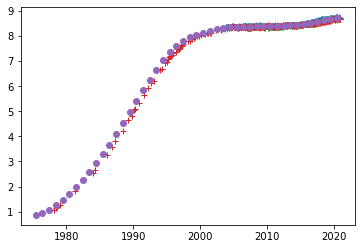

In [45]:
plt.plot(inv.obs.time,inv.obs.mf,"+")
plt.plot(inv.outputs.mf_global_annual[0], inv.outputs.mf_global_annual[1],"o")

In [46]:
inv.outputs.__dict__.keys()

dict_keys(['species', 'uncertainty', 'first_year', 'mf', 'steady_state_lifetime_strat', 'steady_state_lifetime_ocean', 'steady_state_lifetime_oh', 'steady_state_lifetime_cl', 'steady_state_lifetime_othertrop', 'steady_state_lifetime', 'mf_model', 'mf_global_annual', 'mf_global_annual_jan', 'mf_global_growth', 'mf_growth', 'emissions_global_annual', 'emissions_global_annual_nosys', 'emissions_annual', 'emissions_annual_nosys', 'emissions'])

(2015.0, 2021.0)

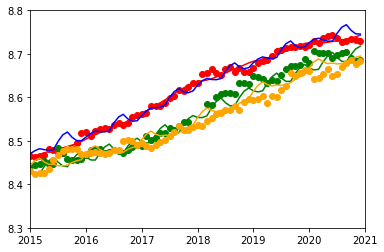

In [47]:
for i, c in enumerate(["r","b","g","orange"]):
    plt.plot(inv.obs.time,inv.obs.mf[:,i], "o", color=c)
    plt.plot(inv.outputs.mf_model[0], inv.outputs.mf_model[1][:,i], color=c)# plt.xlim((2001,2002))
plt.ylim((8.3,8.8))
plt.xlim((2015,2021))

In [8]:
len()

46

1.0150993126711383

array([1975.45833333, 1976.45833333, 1977.45833333, 1978.45833333,
       1979.45833333, 1980.45833333, 1981.45833333, 1982.45833333,
       1983.45833333, 1984.45833333, 1985.45833333, 1986.45833333,
       1987.45833333, 1988.45833333, 1989.45833333, 1990.45833333,
       1991.45833333, 1992.45833333, 1993.45833333, 1994.45833333,
       1995.45833333, 1996.45833333, 1997.45833333, 1998.45833333,
       1999.45833333, 2000.45833333, 2001.45833333, 2002.45833333,
       2003.45833333, 2004.45833333, 2005.45833333, 2006.45833333,
       2007.45833333, 2008.45833333, 2009.45833333, 2010.45833333,
       2011.45833333, 2012.45833333, 2013.45833333, 2014.45833333,
       2015.45833333, 2016.45833333, 2017.45833333, 2018.45833333,
       2019.45833333, 2020.45833333])

In [24]:
emissions[species]["date"]

0     1978.46
1     1979.46
2     1980.46
3     1981.46
4     1982.46
5     1983.46
6     1984.46
7     1985.46
8     1986.46
9     1987.46
10    1988.46
11    1989.46
12    1990.46
13    1991.46
14    1992.46
15    1993.46
16    1994.46
17    1995.46
18    1996.46
19    1997.46
20    1998.46
21    1999.46
22    2000.46
23    2001.46
24    2002.46
25    2003.46
26    2004.46
27    2005.46
28    2006.46
29    2007.46
30    2008.46
31    2009.46
32    2010.46
33    2011.46
34    2012.46
35    2013.46
36    2014.46
37    2015.46
38    2016.46
39    2017.46
40    2018.46
41    2019.46
42    2020.46
Name: Decimal_date, dtype: float64